In [5]:
!pip install torch torchvision torchaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [6]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric


In [7]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

data = dataset[0]
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv

#define model
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


torch.manual_seed(42)
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:10] = True  # train on 10 nodes
data.test_mask = ~data.train_mask

#training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(201):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

#test
model.eval()
_, pred = model(data).max(dim=1)
correct = int((pred[data.test_mask] == data.y[data.test_mask]).sum())
acc = correct / int(data.test_mask.sum())
print(f'\nTest Accuracy: {acc:.4f}')


Epoch 0, Loss: 1.4003
Epoch 20, Loss: 0.7187
Epoch 40, Loss: 0.3346
Epoch 60, Loss: 0.1663
Epoch 80, Loss: 0.0916
Epoch 100, Loss: 0.0512
Epoch 120, Loss: 0.0317
Epoch 140, Loss: 0.0226
Epoch 160, Loss: 0.0180
Epoch 180, Loss: 0.0153
Epoch 200, Loss: 0.0136

Test Accuracy: 0.7917


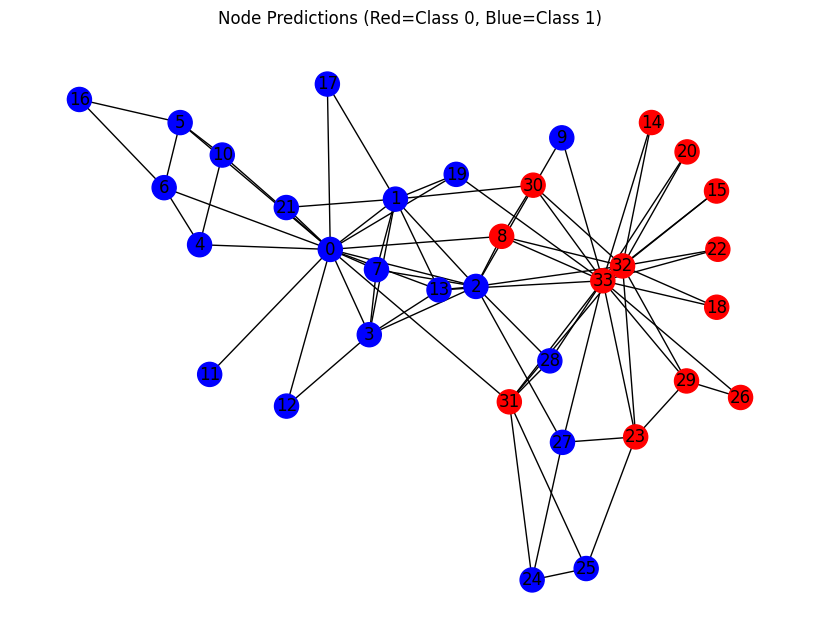

In [12]:
#visualize

import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(8, 6))

color_map = ['red' if pred[i] == 0 else 'blue' for i in range(data.num_nodes)]
nx.draw(G, node_color=color_map, with_labels=True)
plt.title("Node Predictions (Red=Class 0, Blue=Class 1)")
plt.show()
